# Autoregressive Model: SARIMAX

## SARIMA: Seasonal Autoregressive Integrated Moving Average

### Parameter Selection

We will use a **grid search** to find the optimal set of parameters that yields the best performance for our model.

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data
from prepare import prep_store_data

In [2]:
df = prep_store_data(get_store_data())

For this lesson, we'll only be using the date and the sales amounts to make and test our predictions.

In [3]:
aggregation = 'mean' # we might switch this for sum

train = df[:'2016'].sale_amount.resample('D').agg(aggregation)
test = df['2017':].sale_amount.resample('D').agg(aggregation)

In [4]:
p = d = q = range(0, 2)
pdq = list(it.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(it.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


*The **Akaike information criterion (AIC)** is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.*

In [5]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:15687.689769332661
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13847.030379795113
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:10977.798328344414
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:10554.086508123186
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10973.644154408197
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:10637.168447313894
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10743.677774019397
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:10555.961084760967
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13797.91432187399
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12163.04940837713
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:10626.306647772257
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10320.874488215446
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:10511.413729542855
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:10403.120339566902
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:10479.35795950759
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10205.029569196244
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:10447.714595321917
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:10371.68166194

The above output suggests that SARIMAX(1, 1, 1)x(1, 0, 1, 12) yields the lowest AIC value of 9552.77. Therefore we should consider this to be optimal option.

In [6]:
yhat = pd.DataFrame(dict(actual=test))

In [7]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

In [8]:
yhat['sarimax'] = mod.predict(start='20170101', end='20171231', dynamic=True)
yhat.head()

,actual,sarimax
sale_date,,
2017-01-01,47.418,46.539907
2017-01-02,31.544,42.342043
2017-01-03,37.300,44.249943
2017-01-04,37.020,41.962873
2017-01-05,39.790,45.296682


In [9]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))
    
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)
    
    plt.legend(loc='best')
    plt.show()

    
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)
    
    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    
    
    
def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    
    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)
        
    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)
    
    plt.legend(loc='best')
    plt.show()    

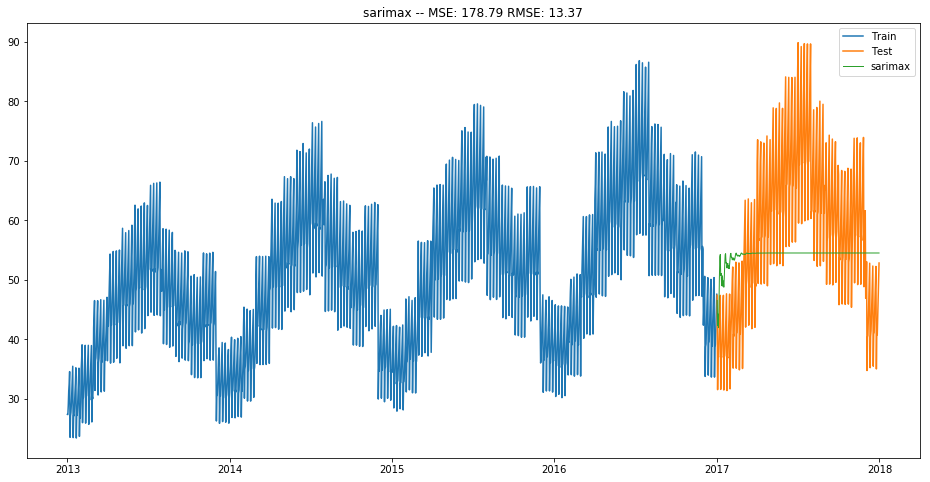

In [10]:
plot_and_eval(yhat.sarimax, linewidth=1)

In [11]:
print(mod.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1535      0.058      2.658      0.008       0.040       0.267
ma.L1         -0.7960      0.030    -26.719      0.000      -0.854      -0.738
ar.S.L12       0.4574      0.040     11.362      0.000       0.379       0.536
ma.S.L12      -0.9044      0.017    -53.045      0.000      -0.938      -0.871
sigma2        42.4099      1.723     24.616      0.000      39.033      45.787


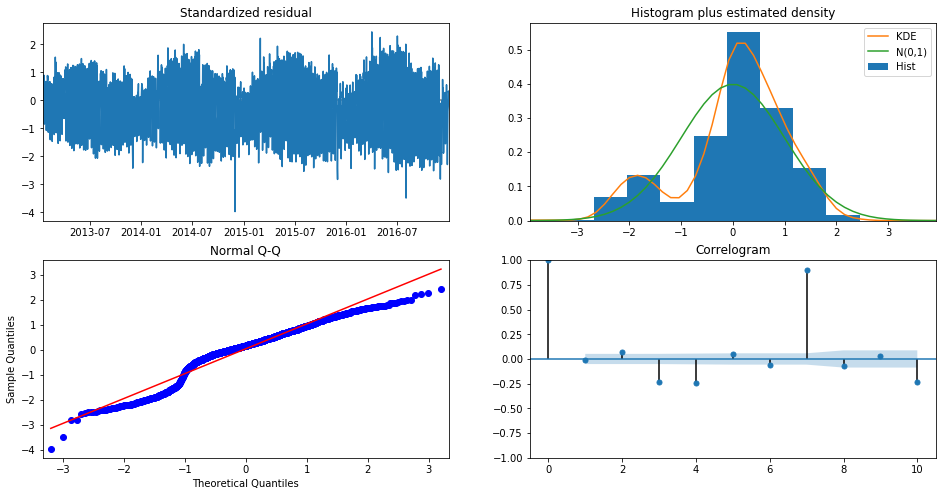

In [12]:
mod.plot_diagnostics(figsize=(16, 8))
plt.show()